In [274]:
from sympy.physics.quantum.state import Bra, Ket
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import qapply, Bra, Ket
from sympy.matrices import Matrix
from sympy import expand, symbols, exp, I, re, cos, sin, pi
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

from tqdm.auto import tqdm

/Users/la-cyrusyc/miniconda3/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. (a)

**1D nanotube/wire**

In [184]:
sa, sb, sc, sd = Ket("SA"), Ket("SB"), Ket("SC"), Ket("SD")

Phi = Matrix(
    [
        0.5 * (sa + sd + sc + sb),
        0.5 * (sa - I * sd - sc + I * sb),
        0.5 * (sa - sd + sc - sb),
        0.5 * (sa + I * sd - sc - I * sb),
    ]
).T

Phi = expand(Phi)


In [185]:
# inner product of bras and kets
h = Phi.applyfunc(lambda i: Dagger(i)).T * Phi
# sympy syntax to apply quantum operation
h = h.applyfunc(lambda i: qapply(expand(i)).doit())

In [186]:
H = h
Es = symbols("Es", real=True)
Ep = symbols("Ep", real=True)
sss = symbols(r"ss\sigma", real=True)
sps = symbols(r"sp\sigma", real=True)
pps = symbols(r"ps\sigma", real=True)
ppp = symbols(r"pp\pi", real=True)

# atomic orbital basis
orbitals = [sa, sb, sc, sd]

circle = "ABCD"

order = len(circle)

# repalce predefined inner products of bras and kets
for oi in orbitals:
    for oj in orbitals:
        if oi == oj and oi in [sa, sb, sc, sd]:
            H = H.subs(oi.dual * oj, Es)
            continue

        stri, strj = str(oi), str(oj)

        i = circle.index(stri[2])
        j = circle.index(strj[2])

        dist = min((i - j) % order, (j - i) % order)

        if dist == 2:
            H = H.subs(oi.dual * oj, 0)
            continue
        if dist == 0 and oi != oj:
            H = H.subs(oi.dual * oj, 0)
            continue

        if stri[1] == "S" and strj[1] == "S":
            H = H.subs(oi.dual * oj, sss)
            continue

$$\left|\Phi^k \right \rangle = \frac{1}{\sqrt{L}} \sum_{u=0}^{L-1} e^{-i \frac{2\pi}{L}j u} \left|\phi_{L-u}\right\rangle = \frac{1}{\sqrt{L}} \sum_{u=0}^{L-1} e^{-i k ua}\left|\phi_{L-u}\right\rangle$$ 

In [290]:
a = symbols('a', real=True)
k = symbols('k', real=True)

Hk_wire = H.as_mutable()

Hk_wire[0, 0] +=  2*sss*cos(k*a)
Hk_wire[1, 1] +=  1/2*sss*cos(k*a)
Hk_wire[3, 3] +=  1/2*sss*cos(k*a)


In [291]:
Hk_wire

Matrix([
[1.0*Es + 2*ss\sigma*cos(a*k) + 2.0*ss\sigma,                              0,                     0,                              0],
[                                          0, 1.0*Es + 0.5*ss\sigma*cos(a*k),                     0,                              0],
[                                          0,                              0, 1.0*Es - 2.0*ss\sigma,                              0],
[                                          0,                              0,                     0, 1.0*Es + 0.5*ss\sigma*cos(a*k)]])

In [292]:
r = symbols("r", real=True)
n = 2.00
nc = 6.5
rc = 2.18
ro = 1.536
ao = 1.2
betar = (ro / r) ** n * exp(n * (-((r / rc) ** nc) + (ro / rc) ** nc))

betar = betar.subs(r, ao)

Hk_wire = Hk_wire.subs(
    [
        (Es, 0),
        # (Ep, 3.71),
        (sss, -5.00 * betar),
        # (sps, 4.70 * betar),
        # (pps, 5.50 * betar),
        # (ppp, -1.55 * betar),
    ]
)

Hk_wire = Hk_wire.subs(
    [
        # (r, ao),
        (a, ao)
    ]
) / abs(sss.subs(sss, -5.00 * betar))

Hk_wire

Matrix([
[-2.0*cos(1.2*k) - 2.0,               0,   0,               0],
[                    0, -0.5*cos(1.2*k),   0,               0],
[                    0,               0, 2.0,               0],
[                    0,               0,   0, -0.5*cos(1.2*k)]])

In [293]:
G = 0
X = pi/a.subs(a, ao)

npts = int(1e3)

# bandstructure
xs = np.linspace(0, 1, npts)
ks = np.linspace(G, float(X), npts)

kes = []

for ki in ks:
    Hsub = Hk_wire.subs(k, ki)
    kes.append([ki, float(Hsub[0, 0])])
    kes.append([ki, float(Hsub[1, 1])])
    kes.append([ki, float(Hsub[2, 2])])
    kes.append([ki, float(Hsub[3, 3])])

kes = np.array(kes)

# dos

L = int(2e3) - 1
ks = np.linspace(-float(X), float(X), L, endpoint=False)

KES = []

for ki in ks:
    Hsub = Hk_wire.subs(k, ki)
    KES.append([ki, float(Hsub[0, 0])])
    KES.append([ki, float(Hsub[1, 1])])
    KES.append([ki, float(Hsub[2, 2])])
    KES.append([ki, float(Hsub[3, 3])])


KES = np.array(KES)
KES[:, 1] = KES[:, 1]
emin, emax = KES[:, 1].min(), KES[:, 1].max()
erange = emax - emin
bins = np.linspace(emin - erange*0.05, emax + erange*0.05, int(200))
dos, bins = np.histogram(KES[:, 1], bins=bins)

bin_centers =  (bins[1:]+bins[:-1])*0.5
bin_widths = np.diff(bins)

dos = dos * 2 / L / bin_widths / 4

# sanity check

np.isclose(np.trapz(dos, bin_centers), 2)

True

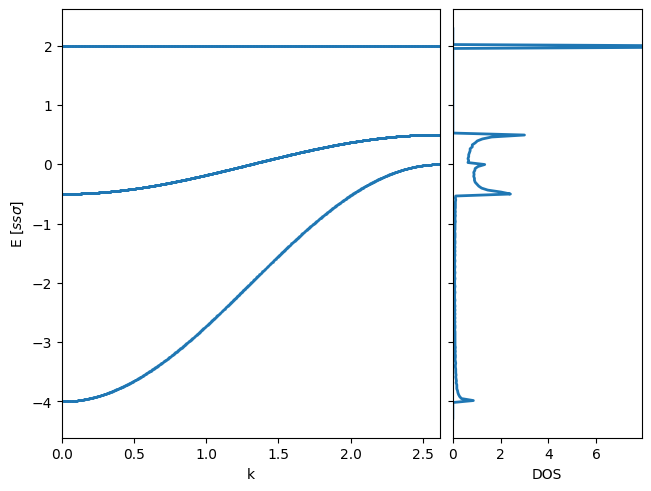

Normalized moment (0): 1.0
Normalized moment (1): -0.003912689645290588
Normalized moment (2): 2.5470100396022985
Normalized moment (3): -3.0414295967265508
Normalized moment (4): 21.373185197368525


In [294]:


with plt.style.context('default'):
    
    LINE_WIDTH = 2

    fig, ax = plt.subplot_mosaic("""
                                 ab
                                 """, 
                                 sharey=True,
                                 width_ratios=[1, 0.5],
                                 constrained_layout=True)
    
    i = 'a'

    ax[i].scatter(kes[:, 0], kes[:, 1], s=0.25*LINE_WIDTH)

    ax[i].set(
        xlabel='k',
        xlim=(kes[:, 0].min(), kes[:, 0].max()),
        ylabel='E [$ss\\sigma$]'
    )

    i = 'b'

    ax[i].plot(dos, bin_centers, lw=LINE_WIDTH)

    xlo, xhi = ax[i].get_xlim()
    ax[i].set(
        xlabel='DOS',
        xlim=(0, 0.5*xhi),
    )
    
    plt.show()

for n in range(5):
    print(f"Normalized moment ({n}):", (dos * bin_centers**n).sum() / dos.sum())

dos_wire = dos
bin_wire = bin_centers

**2D crystal**

In [283]:

k = symbols("k")
a, b = symbols("a, b")

Hk_plane = Es + 2*sss*(cos(k*a) + cos(k*b))

Hk_plane = Hk_plane.subs(
    [
        (Es, 0),
        (sss, -4 * betar),
    ]
) / abs(sss.subs(sss, -4 * betar))

Hk_plane

-2.0*cos(a*k) - 2.0*cos(b*k)

In [284]:

# bandstructure
G = [0, 0]
X = np.array([np.pi, 0])/ao
M = np.array([np.pi, np.pi])/ao

npts = int(1e3)

ks = np.concatenate(
    (
        np.linspace(G, X, npts, endpoint=False), 
        np.linspace(X, M, npts, endpoint=False),
        np.linspace(M, G, npts, endpoint=True)
    ), 
    axis=0
)

kes = []
path = 0

kpre = ks[0][0]*R.i + ks[0][1]*R.j

for ki in ks:

    ksub = ki[0]*R.i + ki[1]*R.j
    Hsub = Hk_plane.subs(
        [
            (k*a, ksub&-R.j),
            (k*b, ksub&R.i)
        ]
    )

    path += float((ksub - kpre).magnitude())
    kpre = ksub

    kes.append([path, float(Hsub)])
    
kes = np.array(kes)

# dos

L = int(2e2)

kas, kbs = np.meshgrid(
    np.linspace(-np.pi/ao, np.pi/ao, L, endpoint=False),
    np.linspace(-np.pi/ao, np.pi/ao, L, endpoint=False)
)

ks = np.stack((kas, kbs), axis=-1).reshape(-1, 2)

KES = []

for ki in tqdm(ks):
    ksub = ki[0]*R.i + ki[1]*R.j
    Hsub = Hk_plane.subs(
        [
            (k*a, ksub&-R.j),
            (k*b, ksub&R.i)
        ]
    )
    KES.append(float(Hsub))

KES = np.array(KES)
emin, emax = KES.min(), KES.max()
erange = emax - emin
bins = np.linspace(emin - erange*0.05, emax + erange*0.05, int(200))
dos, bins = np.histogram(KES, bins=bins)

bin_centers =  (bins[1:]+bins[:-1])*0.5
bin_widths = np.diff(bins)

dos = dos * 2 / (L**2) / bin_widths / 1

# sanity check

np.isclose(np.trapz(dos, bin_centers), 2)

100%|██████████| 40000/40000 [00:09<00:00, 4184.35it/s]


True

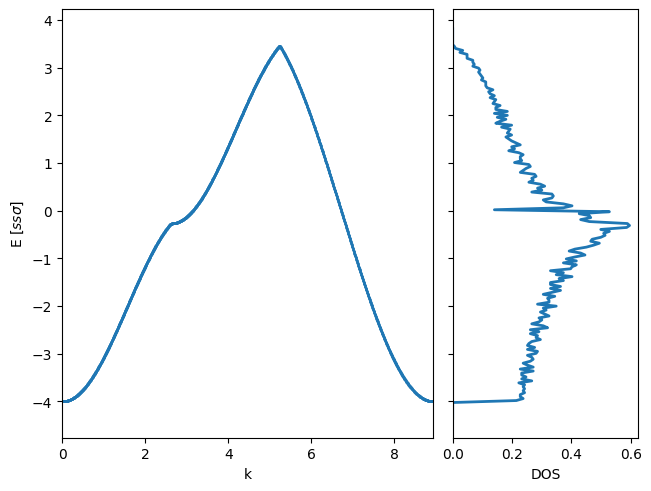

Normalized moment (0): 1.0
Normalized moment (1): -0.7639548732178024
Normalized moment (2): 3.628812499680652
Normalized moment (3): -6.624205165857822
Normalized moment (4): 29.998001697893876


In [289]:
with plt.style.context('default'):
    
    LINE_WIDTH = 2

    fig, ax = plt.subplot_mosaic("""
                                 ab
                                 """, 
                                 sharey=True,
                                 width_ratios=[1, 0.5],
                                 constrained_layout=True)
    
    i = 'a'

    ax[i].scatter(kes[:, 0], kes[:, 1], s=0.25*LINE_WIDTH)

    ax[i].set(
        xlabel='k',
        xlim=(kes[:, 0].min(), kes[:, 0].max()),
        ylabel='E [$ss\\sigma$]'
    )

    i = 'b'

    ax[i].plot(dos, bin_centers, lw=LINE_WIDTH)

    xlo, xhi = ax[i].get_xlim()
    ax[i].set(
        xlabel='DOS',
        xlim=(0, xhi),
    )
    
    plt.show()

for n in range(5):
    print(f"Normalized moment ({n}):", (dos * bin_centers**n).sum() / dos.sum())
dos_plane = dos
bin_plane = bin_centers

We can see that the shapes and characteristics of the density of states look different for 1D wire and 2D plane. 1D wire usually has multiple jumps followed by tails. This is observed in the DOS of wire. 2D crystal is characterized by the sudden jump in the DOS as well but followed by pleateu or satuation instead of depletion. There are called van Hove singularities and could be used to classify the dimensionality of the systems.

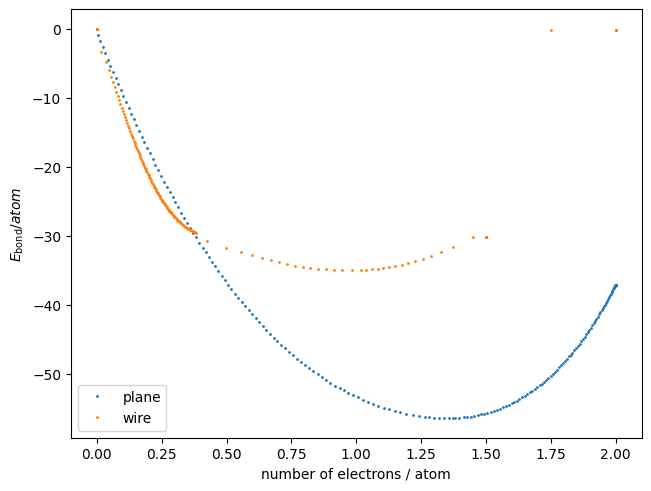

In [315]:



with plt.style.context('default'):
    
    LINE_WIDTH = 2

    fig, ax = plt.subplot_mosaic("""
                                 a
                                 b
                                 """, 
                                 sharex=True,
                                 constrained_layout=True)
    
    iax = 'a'

    x, y = [], []
    for i in range(len(dos_plane)):
        nelec = np.trapz(dos_plane[:i], bin_plane[:i])
        energy = np.sum(dos_plane[:i] * bin_plane[:i])
        x.append(nelec)
        y.append(energy)
    
    ax[iax].plot(x, y, 'o', label='plane', lw=LINE_WIDTH, ms=0.5*LINE_WIDTH)

    x, y = [], []
    for i in range(len(dos_wire)):
        nelec = np.trapz(dos_wire[:i], bin_wire[:i])
        energy = np.sum(dos_wire[:i] * bin_wire[:i])
        x.append(nelec)
        y.append(energy)
    
    ax[iax].plot(x, y, 'o', label='wire', lw=LINE_WIDTH, ms=0.5*LINE_WIDTH)
    # ax[i].plot(x, be_rot_all, '-o', label='rotated')

    # ax[i].axvline(12, ls='--', c='k')

    ax[iax].legend()
    ax[iax].set(
        xlabel='number of electrons / atom',
        ylabel='$E_\\text{bond} / atom$'
    )

    # iax = 'b'

    # ax[iax].plot(dos_plane, bin_plane, label='plane', lw=LINE_WIDTH)

    plt.show()

If the moments are equal up to the second moments for two systems, the band energy curves are expected to croass at least one times according to moments theorem. As the third moments are drastically different, once we apply equility of second moments, we could say that the curves are equivalent up to second moments and will cross at least one time. 

This is consistent with the above bond energy curves as a function of electron occupancy. 